# Import

In [4]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from gemseo import from_pickle
from lh2pac.utils import update_default_inputs
from gemseo_oad_training.unit import convert_from


configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [5]:
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [6]:
update_default_inputs(disciplines, {"slst": 103361.02397518, "n_pax":120, "area":103.45450184, "ar":15.16956933, "fuel_type":"liquid_h2"})
disciplines[0].io.input_grammar.defaults

{'area': 103.45450184, 'ar': 15.16956933, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [8]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

# Import surrogate model

In [10]:
surrogate_disciplines = from_pickle("UC2_my_surrogate_2.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 20
   Surrogate model: RBFRegressor
   Inputs: aef, cef, gi, sef, vi
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# create sample dataset


In [11]:
surrogate_dataset = sample_disciplines([surrogate_disciplines], uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=5000)

 WARNING - 17:40:46: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:40:46: *** Start Sampling execution ***
    INFO - 17:40:46: Sampling
    INFO - 17:40:46:    Disciplines: RBF_Sampling
    INFO - 17:40:46:    MDO formulation: MDF
    INFO - 17:40:46: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:41:05:    100%|██████████| 5000/5000 [00:18<00:00, 265.42 it/sec]
    INFO - 17:41:05: *** End Sampling execution (time: 0:00:18.938461) ***


# Check stat

In [12]:
statistics = EmpiricalStatistics(surrogate_dataset)
mean = statistics.compute_mean()
print(mean)

std = statistics.compute_standard_deviation()
print(std)

{'aef': array([1.00677577]), 'cef': array([1.00675571]), 'fm': array([0.25562752]), 'gi': array([0.38476638]), 'length': array([34.75]), 'mtom': array([64458.18646731]), 'sef': array([1.0066107]), 'span': array([39.61515162]), 'tofl': array([2016.22795274]), 'vapp': array([73.46528015]), 'vi': array([0.78662059]), 'vz': array([4.84642326])}
{'aef': array([0.00852103]), 'cef': array([0.00864282]), 'fm': array([0.02043105]), 'gi': array([0.01243155]), 'length': array([0.]), 'mtom': array([543.06632467]), 'sef': array([0.00841865]), 'span': array([0.]), 'tofl': array([32.38438925]), 'vapp': array([0.31834692]), 'vi': array([0.01121262]), 'vz': array([0.14428962])}


# Propagate uncertainties

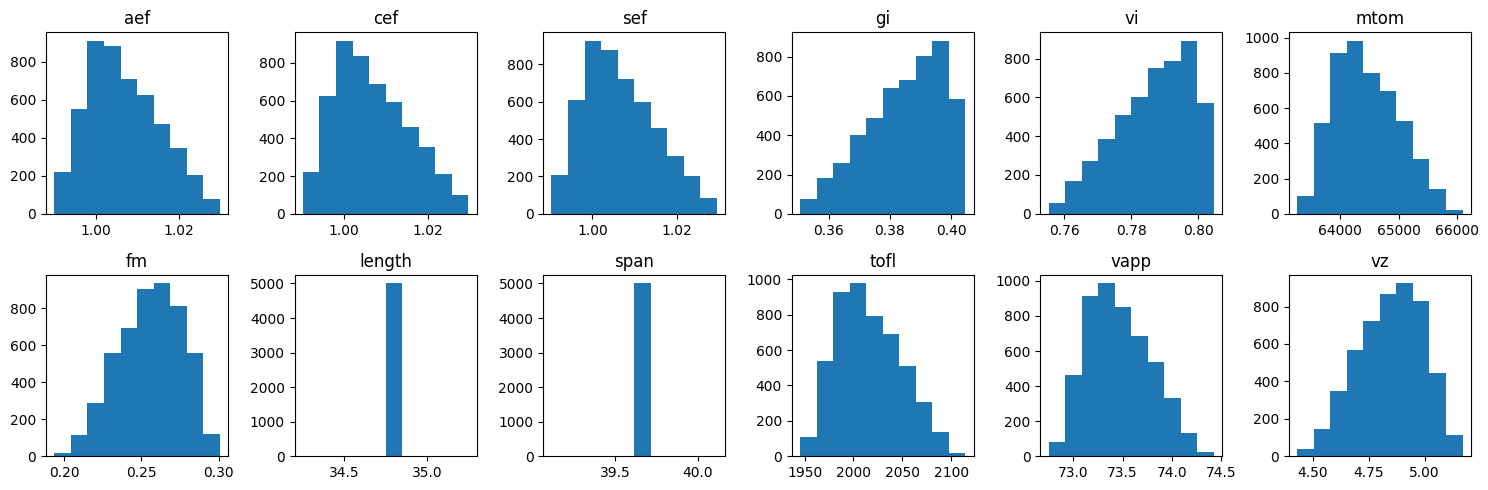

In [13]:
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

axes = axes.ravel()

for ax, name in zip(axes, ["aef", "cef", "sef", "gi", "vi", "mtom", "fm", "length", "span", "tofl", "vapp", "vz"]):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data)
    ax.set_title(name)

plt.tight_layout()
plt.show()

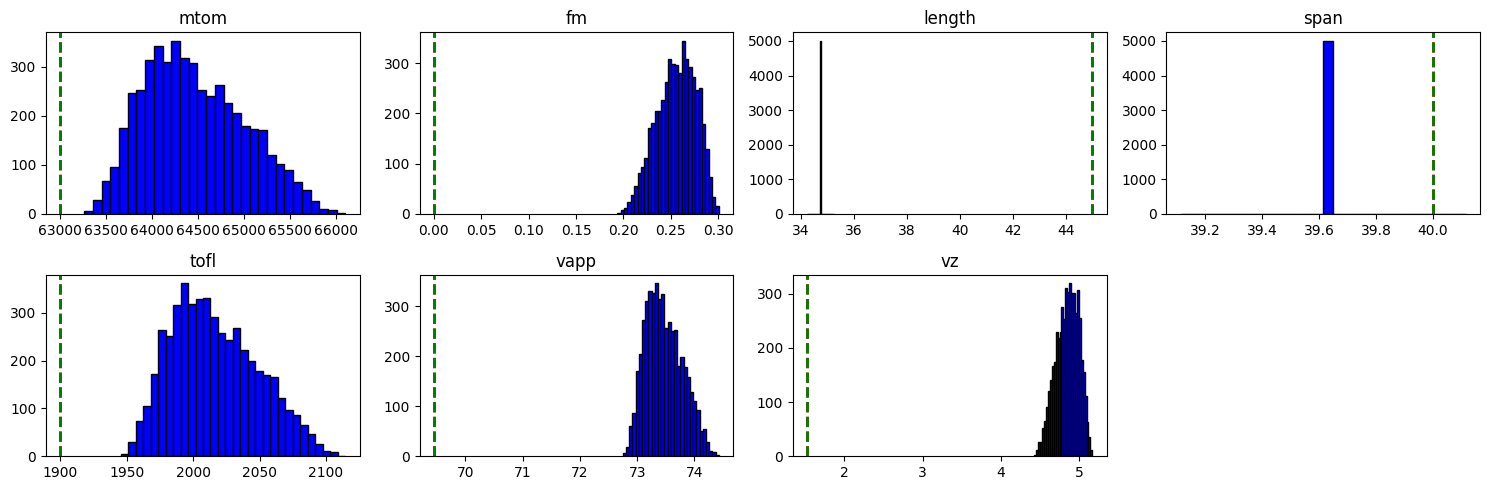

In [17]:
variable_names = ["mtom", "fm", "length", "span", "tofl", "vapp", "vz"]

constraints = [63000, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 
optimum_values = [63000, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.ravel()

for ax, name, cons_val, opt_val in zip(axes, variable_names, constraints, optimum_values):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='blue', edgecolor='black')
    ax.axvline(cons_val, color='red', linestyle='--', linewidth=2)
    ax.axvline(opt_val, color='green', linestyle='--', linewidth=2)

    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


# Sobol analysis

In [18]:
sobol = SobolAnalysis()
samples = sobol.compute_samples([surrogate_disciplines], uncertain_space, 10000)
sobol = SobolAnalysis(samples)
sobol.compute_indices(output_names=["mtom"])

 WARNING - 17:44:02: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:44:02: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:44:02: SobolAnalysisSamplingPhase
    INFO - 17:44:02:    Disciplines: RBF_Sampling
    INFO - 17:44:02:    MDO formulation: MDF
    INFO - 17:44:02: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:44:41:    100%|██████████| 9996/9996 [00:39<00:00, 253.32 it/sec]
    INFO - 17:44:41: *** End SobolAnalysisSamplingPhase execution (time: 0:00:39.662600) ***


SobolAnalysis.SensitivityIndices(first={'mtom': [{'aef': array([0.04138162]), 'cef': array([0.04595295]), 'sef': array([0.27434878]), 'gi': array([0.77418367]), 'vi': array([0.09440598])}]}, second={'mtom': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07855708]]), 'sef': array([[-0.07875563]]), 'gi': array([[-0.08451664]]), 'vi': array([[-0.07977238]])}, 'cef': {'aef': array([[-0.07855708]]), 'cef': array([[0.]]), 'sef': array([[-0.0870732]]), 'gi': array([[-0.08527987]]), 'vi': array([[-0.08926047]])}, 'sef': {'aef': array([[-0.07875563]]), 'cef': array([[-0.0870732]]), 'sef': array([[0.]]), 'gi': array([[-0.08570279]]), 'vi': array([[-0.06919277]])}, 'gi': {'aef': array([[-0.08451664]]), 'cef': array([[-0.08527987]]), 'sef': array([[-0.08570279]]), 'gi': array([[0.]]), 'vi': array([[-0.11843177]])}, 'vi': {'aef': array([[-0.07977238]]), 'cef': array([[-0.08926047]]), 'sef': array([[-0.06919277]]), 'gi': array([[-0.11843177]]), 'vi': array([[0.]])}}]}, total={'mtom': [{'aef': arr

In [19]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'mtom': [{'aef': array([0.04138162]),
           'cef': array([0.04595295]),
           'gi': array([0.77418367]),
           'sef': array([0.27434878]),
           'vi': array([0.09440598])}]}
{'mtom': [{'aef': array([0.00091843]),
           'cef': array([-0.00163397]),
           'gi': array([0.69801065]),
           'sef': array([0.22976084]),
           'vi': array([0.03323702])}]}


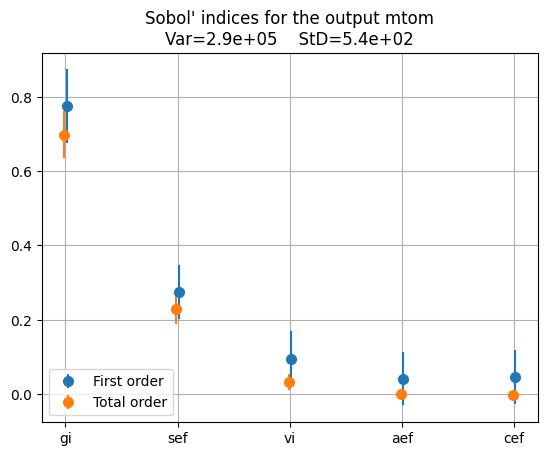

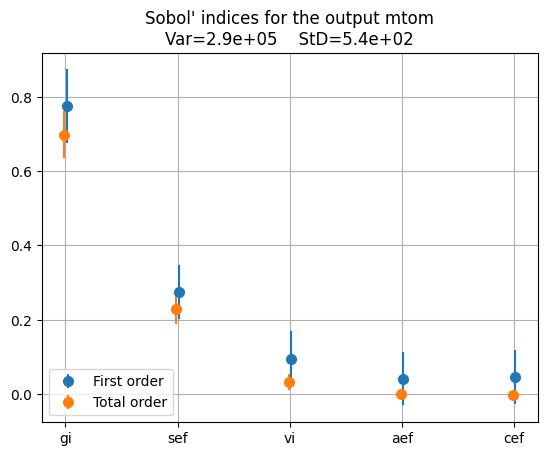

In [20]:
sobol.plot("mtom", save=False, show=False)